In [ ]:
pip install pykrige


In [162]:
import numpy as np

# Define grid
grid_lon = np.arange(100.119736916, 104.324765220, 0.09)
grid_lat = np.arange(1.255854330,6.721694625, 0.09)

metadata = {
    'API_18': 
    {
        'data_source': 'PreparedDataSet\\API_18.csv',
        'variogram_model': 'spherical',
        'range' : 1.5,
        'nugget' : 25,
        'sill' : 43
    },
    'API_19': # havent tune
    {
        'data_source': 'PreparedDataSet\\API_19.csv',
        'variogram_model': 'spherical',
        'range' : 1.5,
        'nugget' : 25,
        'sill' : 43
    },
    'Meteo_18': # havent tune
    {
        'data_source': 'PreparedDataSet\\Meteo_18.csv',
        'variogram_model': 'spherical',
        'range' : 1.5,
        'nugget' : 25,
        'sill' : 43
    },
    'Meteo_19': # havent tune
    {
        'data_source': 'PreparedDataSet\\Meteo_19.csv',
        'variogram_model': 'spherical',
        'range' : 1.5,
        'nugget' : 25,
        'sill' : 43
    },
    'Vegetation_18': # havent tune
    {
        'data_source': 'PreparedDataSet\\Vegetation_1819.csv',
        'variogram_model': 'spherical',
        'range' : 1.5,
        'nugget' : 25,
        'sill' : 43
    },
    'Vegetation_19': # havent tune
    {
        'data_source': 'PreparedDataSet\\Vegetation_1819.csv',
        'variogram_model': 'spherical',
        'range' : 1.5,
        'nugget' : 25,
        'sill' : 43
    },
    'Traffic_18': # havent tune
    {
        'data_source': 'PreparedDataSet\\Traffic_1819.csv',
        'variogram_model': 'spherical',
        'range' : 1.5,
        'nugget' : 25,
        'sill' : 43
    },
}

In [166]:
import pandas as pd

data = 'Vegetation_18'

# Read the CSV file
df = pd.read_csv(metadata[data]['data_source'])

print(df.columns)
while True:
    target = input('Please set your target variable: ')
    if target in df.columns:
        break
    else:
        print('Please enter a valid target variable')


# Extract columns
lon = df['lon'].values
lat = df['lat'].values
target = df[target].values



Index(['Unnamed: 0', 'location', 'lon', 'lat', 'treecover2018',
       'treecover2019'],
      dtype='object')


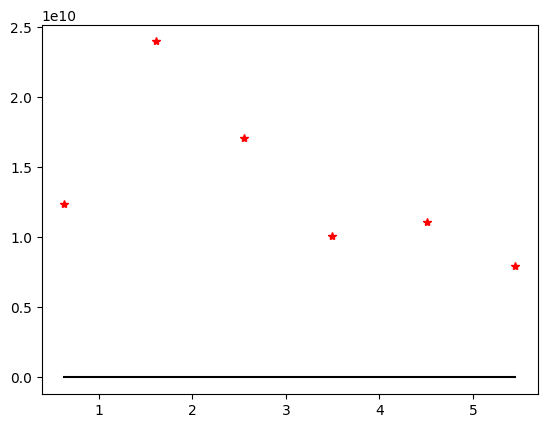

(61, 47)


In [167]:
from pykrige.ok import OrdinaryKriging

# OK = OrdinaryKriging(lon, lat, api, variogram_model='gaussian', enable_plotting=True, verbose=True)
OK = OrdinaryKriging(lon, lat, target, 
                     variogram_model= metadata[data]['variogram_model'] , enable_plotting=True, 
                     variogram_parameters={'range': metadata[data]['range'], 'nugget': metadata[data]['nugget'], 'sill': metadata[data]['sill']})


# Range: the distance beyond which points are not correlated; AKA the spread of influence of each point
# Nugget: the y-intercept of the variogram; AKA the measurement error
# Sill: the maximum variance possible; AKA the measurement variance plus the nugget

z_interp, ss = OK.execute('grid', grid_lon.flatten(), grid_lat.flatten())
print(z_interp.shape)

Text(0.5, 1.0, 'Kriging Interpolation (spherical) for Vegetation_18 in West Malaysia')

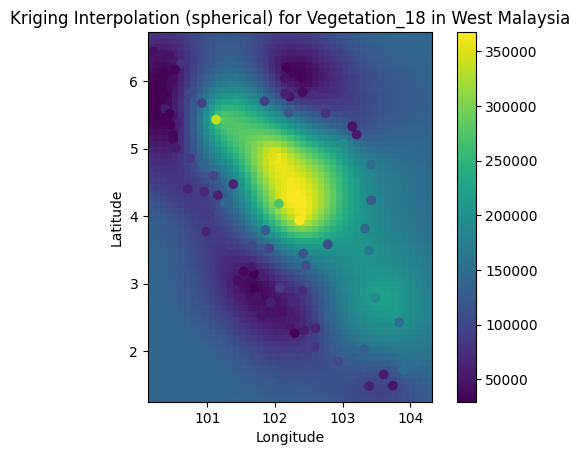

In [168]:
# Check and tune

from matplotlib import pyplot as plt


cax = plt.imshow(z_interp, extent=(100.119736916, 104.324765220, 1.255854330,6.721694625), origin='lower')
plt.scatter(lon, lat, c=target)
plt.colorbar(cax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Kriging Interpolation ({metadata[data]['variogram_model']}) for {data} in West Malaysia')


INTERPOLATION automation


In [ ]:
import pandas as pd

# Convert z_interp to a dataframe
df_z_interp = pd.DataFrame(z_interp)
print(df_z_interp.shape)

# Flip dataframe vertically
df_z_interp = df_z_interp.iloc[::-1]

In [ ]:
# To run R in Jupyter Notebook
%load_ext rpy2.ipython

In [ ]:
%R -i df_z_interp   # Pass the dataframe to R
%R -i data                  # Pass the data name to R

In [ ]:
%%R
# automate insert columns of data from df_z_interp into one column in target dataframe
target2867Structure_file = read.csv('QGIS\\StructureGrid\\2867_holdplace.csv')
hold_data = data.frame()
for (i in 1:47){
  for ( j in 1:61){
    hold_data = rbind(hold_data, df_z_interp[j,i])
  }
}
done = data.frame()
done = cbind(target2867Structure_file, hold_data)
colnames(done)[8] = data

filename = paste('z_interp\\z_interp_', data, '.csv', sep = '')
write.csv(done, filename, row.names = FALSE)

In [ ]:
####
####
#!!!! only run this once to create the final superset csv file
####
####
# SUPERSET
import shutil
source_file = 'QGIS\\Result\\StructureGrid\\966_targetGrid.csv'
destination_file = 'FinalSuperset\\FinalSuperset.csv'
shutil.copyfile(source_file, destination_file)

GO to QGIS
<br><br>
Import z_interp file to QGIS
<br>
<img src="asset\Import_Z_interp.png" alt="alt text" width="500" height="300">
<br><br>
Create Grid based on West Malaysia shapefile (more info, contact me)
<br>
<img src="asset\Create_Grid.png" alt="alt text" width="500" height="300">
<br><br>
Clip the grid to west malaysia
<br>
<img src="asset\Clip_gridToWestMalaysia.png" alt="alt text" width="500" height="300">
<br><br>
Join attribute By Location
<br>
<img src="asset\JoinAttrByLocation.png" alt="alt text" width="500" height="300">
<br><br>
Export the layer as grided_{data}
<br>
<img src="asset\export_Grided.png" alt="alt text" width="500" height="300">
<br><br>
Brief showcase of the four layer, (not including gradien color)
<br>
<img src="asset\briefShowcase.gif" alt="alt text" width="500" height="300">

In [ ]:
%%R
library(dplyr)
# grouping QGIS result into 966 grids/ records
filename = paste('QGIS\\Result\\grided_', data, '.csv', sep = '')
grided_target = read.csv(filename)

grided_target <- grided_target %>% 
    group_by(id, left, top, right, bottom, row_index, col_index) %>% 
    summarize(!!data := mean(!!sym(data)))

# Write the new dataframe to final supeset csv file
superset = read.csv('FinalSuperset\\FinalSuperset.csv')
last_column = ncol(grided_target)
superset = cbind(superset, grided_target[,last_column])
write.csv(superset, 'FinalSuperset\\FinalSuperset.csv', row.names = FALSE)
